In [1]:
import os
import sys
import numpy as np
import matplotlib
matplotlib.use('nbagg')
#from matplotlib import style
#style.use('ggplot')
import matplotlib.pyplot as plt

from skimage import feature
from scipy import stats, ndimage

import photutils

from astropy import units as u
from astropy import stats
from astropy import visualization
from astropy import coordinates
from astropy.table import Table, vstack
from astropy.io import ascii, fits
from astropy.modeling import models, fitting, custom_model

In [195]:
def mk_pupil_model(size=400):
    """
    Use photutils to make an annular mask to use as a model for what a pupil should look like. 
    
    Returns
    -------
    mask:  2D np.ndarray
        Mask containing annular pupil model
    """
    annulus = np.zeros((size, size))
    # this mask will be 1 inside the annulus, 0 outside, and interpolated in pixels that are partially overlapped
    outer = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 180, use_exact=0, subpixels=5)
    inner = photutils.geometry.circular_overlap_grid(-size/2., size/2., -size/2., size/2., size, size, 40, use_exact=0, subpixels=5)
    mask = annulus + outer - inner
    return mask

def plot_wfsfind(data, sources, ap_radius=5.0):
    positions = (sources['xcentroid'], sources['ycentroid'])
    apertures = photutils.CircularAperture(positions, r=ap_radius)
    norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
    plt.imshow(data, cmap='gray', origin='lower', norm=norm, interpolation='None')
    apertures.plot(color='red', lw=1.5, alpha=0.5)

def wfsfind(data, fwhm=5.0, threshold=7.0, plot=False, ap_radius=5.0):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    daofind = photutils.DAOStarFinder(fwhm=fwhm, threshold=threshold*std)
    sources = daofind(data - median)
    if plot:
        plot_wfsfind(data, sources, ap_radius=ap_radius)
    return sources

def get_mag(data):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # sum along the axes and use Lomb-Scargle to measure the grid spacing in each direction
    xsum = np.sum(data, axis=0)
    ysum = np.sum(data, axis=1)
    x = np.arange(len(xsum))
    y = np.arange(len(ysum))
    k = np.linspace(5.0, 50., 1000.)  # look for spacings from 5 to 50 pixels (plenty of range)
    f = 1.0 / k  # convert spacing to frequency
    xp = stats.LombScargle(x, xsum).power(f)
    yp = stats.LombScargle(y, ysum).power(f)   
    xmag = k[xp.argmax()]
    ymag = k[yp.argmax()]
    return xmag, ymag

def mk_reference(data, xparity=0, yparity=0, plot=True):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    spots = wfsfind(data, fwhm=4.0, threshold=30.0, plot=plot)
    xcen = spots['xcentroid'].mean()
    ycen = spots['ycentroid'].mean()
    mag = get_mag(data)
    # just using the mean will be offset from the true center due to missing spots at edges.
    # find the spot closest to the mean and make it the center position of the pattern.
    dist = ((spots['xcentroid'] - xcen)**2 + (spots['ycentroid'] - ycen)**2)
    closest = np.argmin(dist)
    xoff = spots['xcentroid'][closest] - xcen
    yoff = spots['ycentroid'][closest] - ycen
    xcen += xoff
    ycen += yoff
    spots['xcentroid'] -= xcen + xparity*xmag/2.
    spots['ycentroid'] -= ycen + yparity*ymag/2.
    spots['dist'] = np.sqrt(spots['xcentroid']**2 + spots['ycentroid']**2)
    ref = {}
    ref['xmag'] = mag[0]
    ref['ymag'] = mag[1]
    ref['ap_centers'] = spots[(spots['dist'] > 50) & (spots['dist'] < 170)]
    return ref

def center_pupil(data, plot=False):
    if isinstance(data, str):
        # we're a fits file (hopefully)
        data = fits.open(data)[0].data
    # use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
    # the location of the peak of the correlation will be the center of the WFS pattern.
    mask = mk_pupil_model()
    match = feature.match_template(data, mask, pad_input=True)
    match[match < 0.95*match.max()] = 0
    cen = photutils.centroids.centroid_com(match)
    if plot:
        plt.imshow(match, interpolation=None, origin='lower')
    return cen

<IPython.core.display.Javascript object>


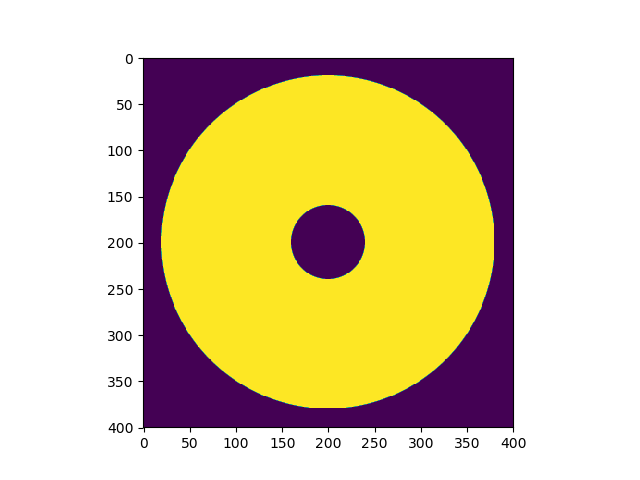

In [3]:
mask = mk_pupil_model()
plt.imshow(mask)
plt.show()

In [4]:
file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0373.fits"
center = ascii.read("/Users/tim/MMT/shwfs/mmirs2_reference.center")
ref = ascii.read("/Users/tim/MMT/shwfs/mmirs2_sysfile.cntr")
ref1_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref2_fits = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits"
# test images from 20170110: 1, 7, 44, 61, 126, 131-138, 161-168, 183-189, 194-198, 298-299, 327, 369-372
test_fits = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0168.fits"

im = fits.open(file)[0].data
ref1_im = fits.open(ref1_fits)[0].data
ref2_im = fits.open(ref2_fits)[0].data
test = fits.open(test_fits)[0].data

<IPython.core.display.Javascript object>


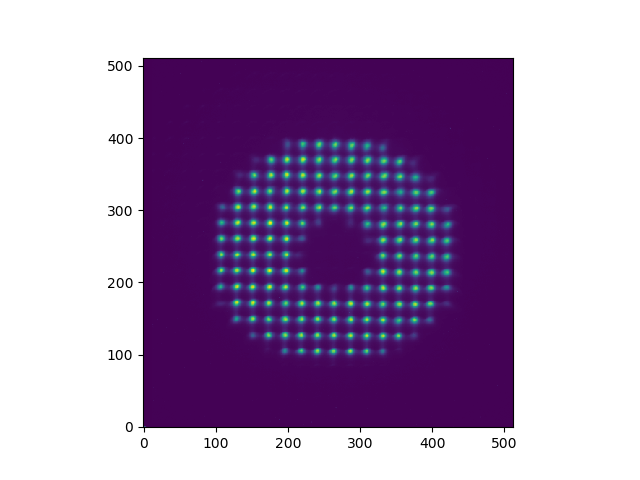

In [5]:
plt.imshow(test, interpolation='nearest', origin='lower')
#plt.scatter(ref['col1'], ref['col2'], color='purple')
#plt.scatter(center['col1'], center['col2'], marker='x', color='white')
#plt.scatter(271, 229, marker='x', color='white')
plt.show()

<IPython.core.display.Javascript object>


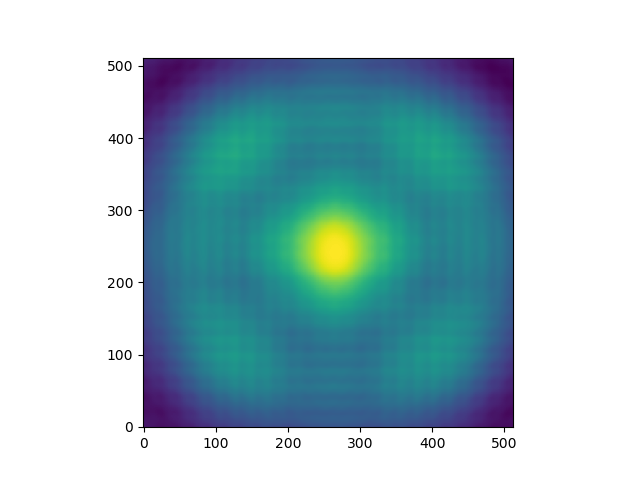

In [6]:
# use skimage.feature.match_template() to do a fast cross-correlation between the WFS image and the pupil model.
# the location of the peak of the correlation will be the center of the WFS pattern.
result = feature.match_template(test, mask, pad_input=True)
plt.imshow(result, interpolation='nearest', origin='lower')
plt.show()

<IPython.core.display.Javascript object>


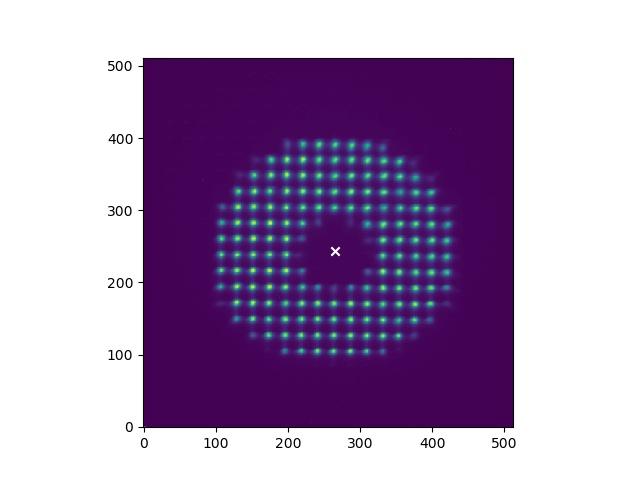

In [7]:
# the correlation image is somewhat complicated, but the peak is distinct as long as there are detectable WFS spots.
# clip the image at 90% of the peak and then do a center-of-mass centroid on it. 
plt.imshow(test, interpolation='nearest', origin='lower')
result[result < 0.9*result.max()] = 0
cen = photutils.centroids.centroid_com(result)
plt.scatter(cen[0], cen[1], marker='x', color='white')
plt.show()

In [8]:
# ndimage and photutils should give the same answer for CoM centroids...
ndimage.center_of_mass(result)

(244.10445659511728, 264.98077038766058)

<IPython.core.display.Javascript object>


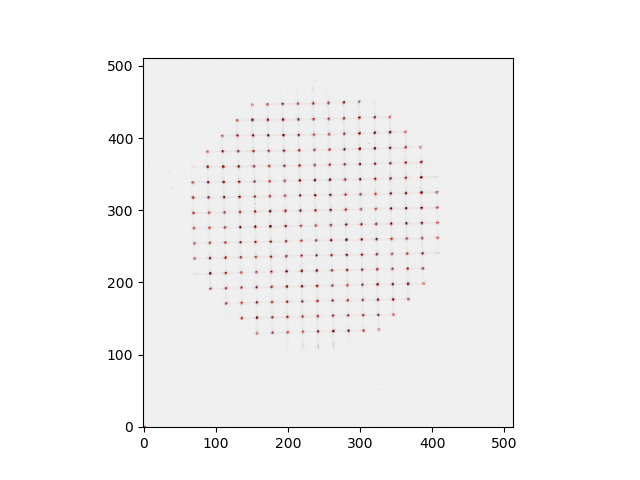

In [9]:
ref_file = "/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits"
ref_data = fits.open(ref_file)[0].data
mean, median, std = stats.sigma_clipped_stats(ref_data, sigma=3.0, iters=5)

daofind = photutils.DAOStarFinder(fwhm=4, threshold=30.0*std)
#starfind = photutils.IRAFStarFinder(fwhm=2.0, threshold=5.0*std)

dao_sources = daofind(ref_data - median)
#iraf_sources = starfind(ref_data - median)

plot_wfsfind(ref_data, dao_sources, ap_radius=0.5)
plt.show()

<IPython.core.display.Javascript object>


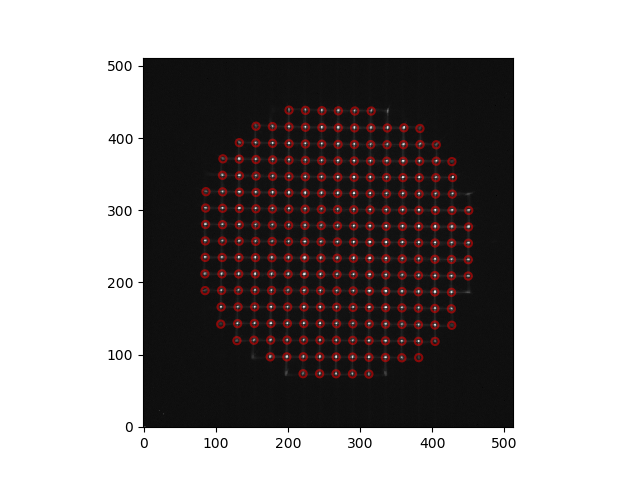

In [197]:
rs = mk_reference("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera2_ref.fits", yparity=1.)
plt.show()

<IPython.core.display.Javascript object>


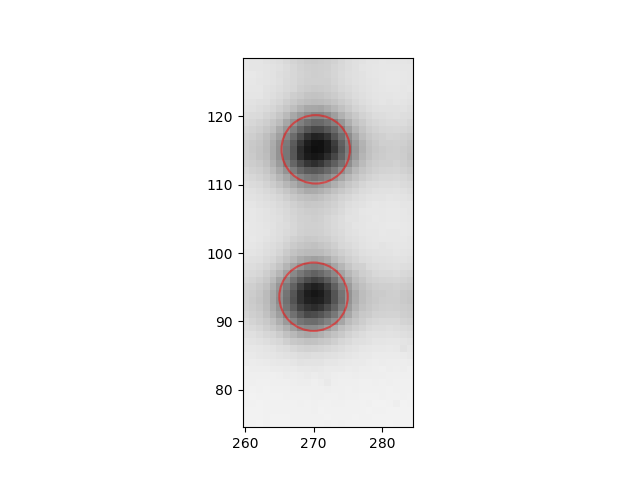

In [31]:
s = wfsfind("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0232.fits", fwhm=7.0, plot=True)
s.sort(['xcentroid'])
plt.show()

In [32]:
s['xcentroid'].mean()

270.40498984482571

<IPython.core.display.Javascript object>


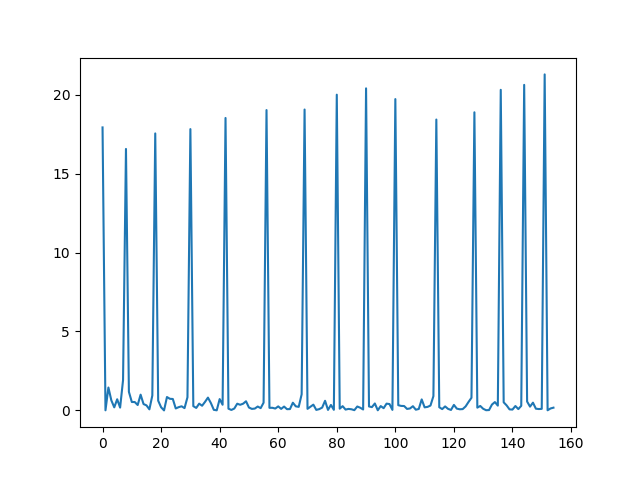

In [52]:
diffs = np.diff(sorted(s['xcentroid']))
plt.plot(diffs)
plt.show()

In [37]:
stats.histogram(rs['xcentroid'], bins='blocks')

(array([ 6,  2,  9,  2, 11,  2, 11,  2, 13,  2, 13,  2, 10,  2, 10,  2, 10,
         2, 13,  2, 13,  2, 11,  2, 11,  2,  9,  2,  6]),
 array([-160.33672559, -158.92712737, -137.83769189, -135.62698406,
        -115.18529072, -112.59264969,  -92.19517952,  -89.65054837,
         -69.75881181,  -66.92357329,  -46.91489512,  -44.19415202,
         -24.17076783,  -21.48402733,   -1.45463521,    1.12687325,
          21.26174694,   23.74603761,   43.88159966,   46.39520331,
          66.68439332,   69.05753286,   89.4625815 ,   91.43507238,
         112.25485893,  114.29695338,  135.07145104,  136.765981  ,
         158.05815736,  159.17088341]))

In [38]:
rs

id,xcentroid,ycentroid,sharpness,roundness1,roundness2,npix,sky,peak,flux,mag,dist
int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64
6,43.8252254356,-159.805821417,0.589815949756,0.25558590703,0.0869819178237,25.0,0.0,21459.0,24.9137359952,-3.49109714506,165.706218783
7,66.6704616338,-160.106815721,0.589401480445,0.0658184754701,0.0520408189762,25.0,0.0,21915.0,25.8185736952,-3.52983061677,173.433396134
11,-69.9313906955,-159.184033933,0.582469491698,0.0701834336945,-0.114857723503,25.0,0.0,20107.0,23.2599182759,-3.41652046123,173.867639496
12,-47.1023075238,-159.129759739,0.597852044571,0.189449571458,-0.023814735824,25.0,0.0,21222.0,24.5231027405,-3.47393854409,165.954535367
13,-24.3098327699,-159.164804961,0.603274648717,0.223939540205,0.0408608056827,25.0,0.0,21758.0,25.3235650842,-3.50881211547,161.010568311
14,-1.57217193317,-159.314627251,0.571211751056,0.269156710209,0.080311961208,25.0,0.0,22735.0,27.4468082243,-3.59622961958,159.32238443
15,21.1697042352,-159.468320474,0.558222999656,0.408443408464,0.0390405487622,25.0,0.0,20313.0,24.1015699982,-3.45511333459,160.867341658
16,112.313536431,-137.73650658,0.561214845258,-0.203646628219,0.119882176459,25.0,0.0,20947.0,24.5814155906,-3.47651722338,177.723593568
19,43.9379738877,-136.655785497,0.586443266991,0.383669266988,0.0691667377769,25.0,0.0,21037.0,24.1346708599,-3.4566034511,143.545634762


(22.027027027027025, 22.072072072072071)


<IPython.core.display.Javascript object>


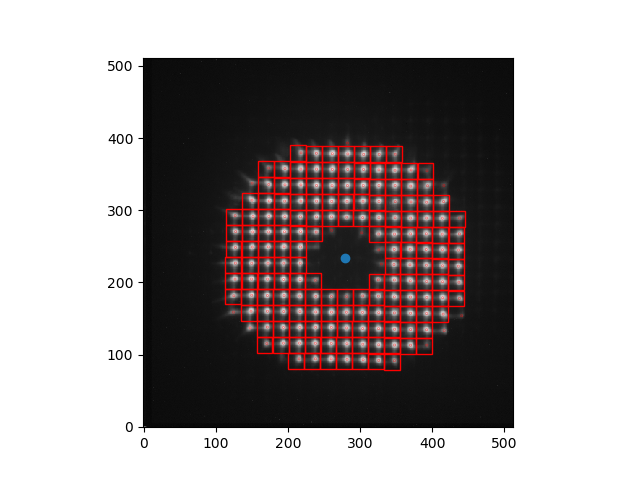

In [196]:
file = "/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0350.fits"
s = wfsfind(file, fwhm=7.0, plot=True, ap_radius=0.5)
s.sort(['flux'])
s.reverse()
cen = center_pupil(file, plot=False)
xmag, ymag = get_mag(file)
print((xmag, ymag))
ref_aps = photutils.RectangularAperture(((xmag/22.66)*rs['xcentroid']+cen[0], (ymag/22.66)*rs['ycentroid']+cen[1]), w=22, h=22, theta=0.0)
ref_aps.plot(color='red')
plt.scatter(cen[0], cen[1])
plt.show()

In [382]:
def get_apertures(data, ref, xcen, ycen, xmag, ymag):
    apers = photutils.CircularAperture(
        ((xmag/ref['xmag'])*ref['ap_centers']['xcentroid']+xcen,
        (ymag/ref['ymag'])*ref['ap_centers']['ycentroid']+ycen),
        r=(xmag + ymag)/4.
    )
    masks = apers.to_mask(method='subpixel')
    pos = []
    for m in masks:
        subim = m.cutout(data)
        #subim[subim < 0.7*subim.max()] = 0.0
        spotx, spoty = photutils.centroid_com(subim)
        pos.append((spotx-m.shape[1]/2, spoty-m.shape[0]/2))
    p = np.array(pos)
    return apers, masks, p
    
def get_slopes(file, ref):
    data = fits.open(file)[0].data
    mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
    data -= median
    xcen, ycen = center_pupil(data, plot=False)
    xmag, ymag = get_mag(data)
    # get initial apertures, find mean offset, and fine tune the centration
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xmag, ymag)
    xcen += pos[0].mean()
    ycen += pos[1].mean()
    apers, masks, pos = get_apertures(data, ref, xcen, ycen, xmag, ymag)
    
    norm = visualization.mpl_normalize.ImageNormalize(stretch=visualization.SqrtStretch())
    plt.imshow(data, cmap='gray', origin='lower', norm=norm, interpolation='None')
    apers.plot(color='red')
    plt.scatter(xcen, ycen)
    return apers, pos, masks, (xmag, ymag), (xcen, ycen), data

<IPython.core.display.Javascript object>


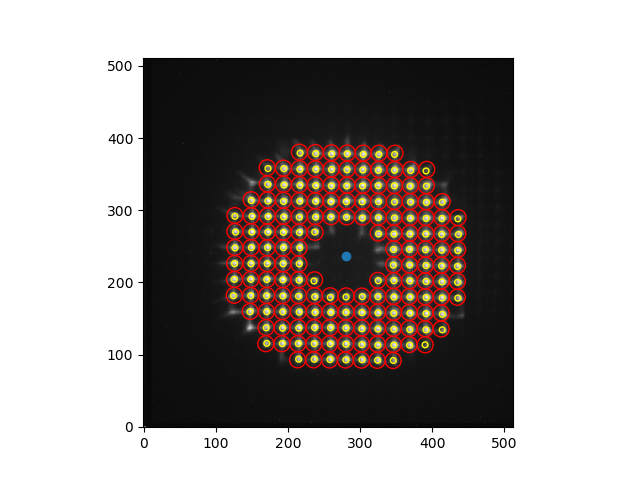

In [383]:
aps, pos, masks, mag, cen, im = get_slopes("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0350.fits", rs)
new_aps = photutils.CircularAperture(
    aps.positions+pos,
    r=4
)
new_aps.plot(color='yellow')
plt.show()

In [324]:
p = np.array(pos)
print(p[0].mean(), p[1].mean())
m = masks[10]

0.0524470933063 -0.655504421136


In [338]:
aps.positions

array([[ 321.54008467,   91.54781438],
       [ 343.66694689,   91.24840209],
       [ 211.17559733,   92.25013248],
       [ 233.3981199 ,   92.1905205 ],
       [ 255.46220804,   92.08074028],
       [ 277.52515348,   91.9906392 ],
       [ 299.58448608,   91.8284123 ],
       [ 387.9577217 ,  113.0307514 ],
       [ 343.76248791,  113.71594689],
       [ 365.81582673,  113.43575898],
       [ 167.14293089,  114.65521125],
       [ 189.40646476,  114.61922583],
       [ 211.56842231,  114.62008569],
       [ 233.6899556 ,  114.58046276],
       [ 255.76637566,  114.52215595],
       [ 277.77025925,  114.32640652],
       [ 299.71683324,  114.20408388],
       [ 321.72383654,  113.99376601],
       [ 387.95328974,  135.33121673],
       [ 410.16399387,  134.91400646],
       [ 321.91536847,  136.16417729],
       [ 343.90249487,  135.9309475 ],
       [ 365.84815077,  135.67297643],
       [ 167.55239613,  137.01226964],
       [ 189.81157201,  137.02029594],
       [ 211.92920366,  1

In [325]:
aps.r, m.shape

(11.024774774774773, (23, 23))

(23, 23)


<IPython.core.display.Javascript object>


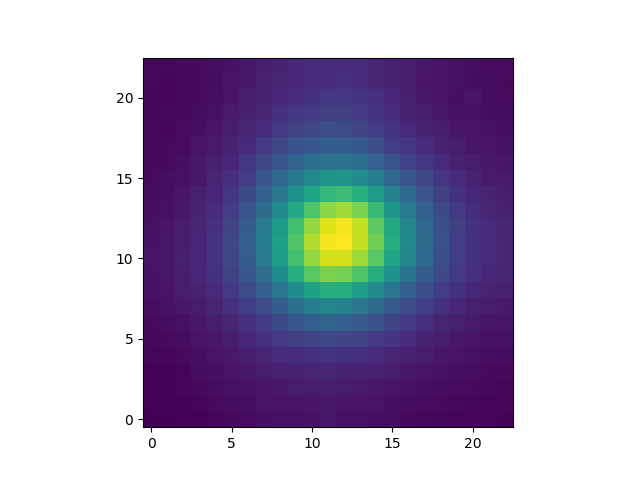

In [311]:
print(masks[10].cutout(data).shape)
plt.imshow(masks[10].cutout(data), origin='lower')
plt.show()

<IPython.core.display.Javascript object>


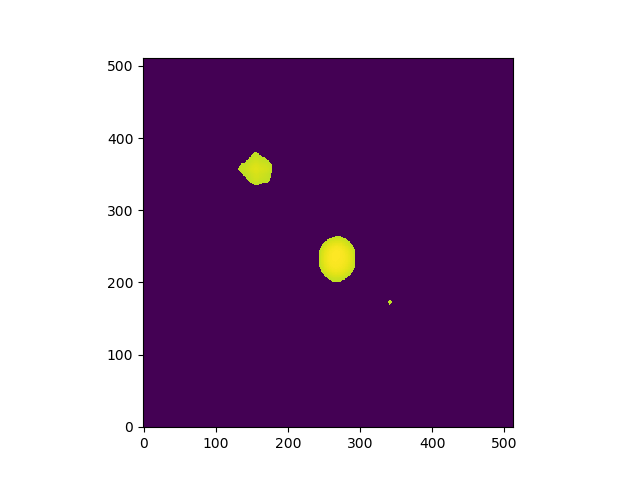

In [167]:
c = center_pupil("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0020.fits", plot=True)
plt.show()

In [20]:
src_coord = coordinates.SkyCoord(representation='cartesian', x=s['xcentroid'], y=s['ycentroid'], z=1.0)
ref_coord = coordinates.SkyCoord(representation='cartesian', x=rs['xcentroid']+cen[0], y=rs['ycentroid']+cen[1], z=1.0)

In [21]:
idx, ang, dist = coordinates.match_coordinates_3d(src_coord, ref_coord)

In [22]:
off_rs = rs.copy()
off_rs['xcentroid'] += cen[0]
off_rs['ycentroid'] += cen[1]
match_rs = off_rs[idx]

In [23]:
ang

<Angle [ 0.59443048, 0.59992675, 0.63990632, 0.85627267, 1.36187759,
         1.72931742, 0.63755019, 1.87592787, 0.65871844, 0.65459379,
         1.35428952, 1.36336149, 1.53045096, 0.55488659, 1.74370203,
         1.89883852, 0.57963776, 1.25828303, 0.70316288, 0.58889494,
         0.80059144, 1.07685631, 2.09866694, 0.77585347, 0.80957531,
         1.98262197, 1.14323318, 1.74372597, 1.38544377, 1.55735991,
         0.70855403, 1.40744061, 2.1178558 , 1.06875511, 1.30480136,
         1.84185928, 0.94809195, 1.42505474, 0.58894994, 1.77380559,
         1.69123458, 1.33813069, 2.07566486, 1.8074708 , 0.60362764,
         0.85569374, 1.67256729, 0.60339195, 1.48884469, 0.6609885 ,
         1.66652131, 0.55179021, 0.83141461, 1.77574457, 0.59650718,
         1.99072428, 1.29564312, 2.08048028, 1.48060286, 2.25526161,
         1.89072618, 1.57837279, 2.03064843, 0.68107991, 1.20728684,
         1.40196529, 1.50033567, 0.81134648, 0.46819645, 1.39733897,
         1.87686582, 1.68068058, 0

In [24]:
def fit_wfs_reference(pars, ref, spots):
    xcen = pars[0]
    ycen = pars[1]
    scale = pars[2]
    model = coordinates.SkyCoord(
        representation='cartesian',
        x=scale*ref['xcentroid'] + xcen,
        y=scale*ref['ycentroid'] + ycen,
        z=0.0
    )
    measured = coordinates.SkyCoord(
        representation='cartesian',
        x=spots['xcentroid'],
        y=spots['ycentroid'],
        z=0.0
    )
    idx, ang, dist = coordinates.match_coordinates_3d(measured, model)
    matched_model = ref[idx]
    dist = (spots['xcentroid'] - matched_model['xcentroid'])**2
    dist += (spots['ycentroid'] - matched_model['ycentroid'])**2
    stat = np.sum(dist) / len(idx)**5
    return stat

In [25]:
from scipy import optimize

In [26]:
pars = [cen[0], cen[1], 1.0]
xopt = optimize.fmin_powell(fit_wfs_reference, pars, xtol=1e-4, args=(rs, s))

Optimization terminated successfully.
         Current function value: 0.000074
         Iterations: 7
         Function evaluations: 460


<IPython.core.display.Javascript object>


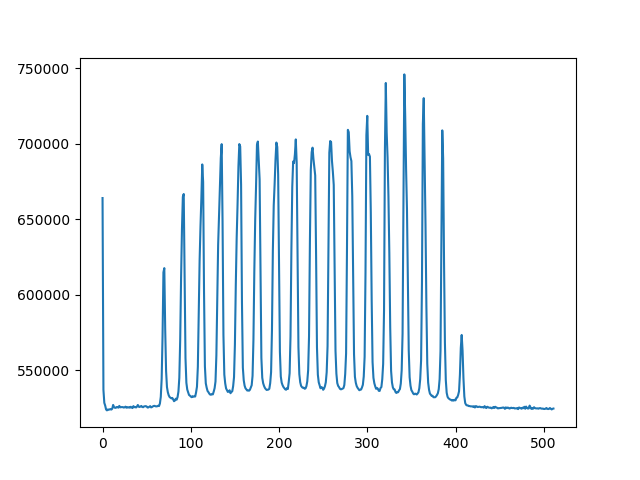

(21.036036036036034, 21.036036036036034)


In [108]:
#data = fits.open("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits")[0].data
data = fits.open("/Users/tim/MMT/mmtwfs/ref_images/mmirs_camera1_ref.fits")[0].data
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(x)
plt.show()
print(get_mag(data))

<IPython.core.display.Javascript object>


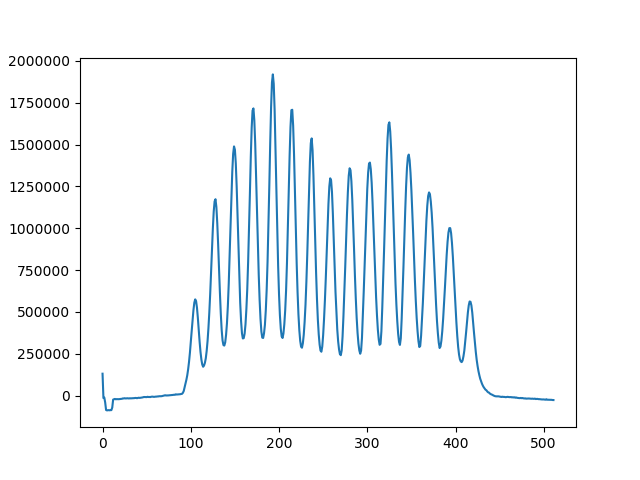

(22.117117117117115, 22.522522522522522)


In [113]:
data = fits.open("/Users/tim/MMT/wfsdat/20170110/rawdata/mmirs_wfs_0138.fits")[0].data
mean, median, std = stats.sigma_clipped_stats(data, sigma=3.0, iters=5)
data -= median
x = np.sum(data, axis=0)
y = np.sum(data, axis=1)
plt.plot(x)
plt.show()
print(get_mag(data))

<IPython.core.display.Javascript object>


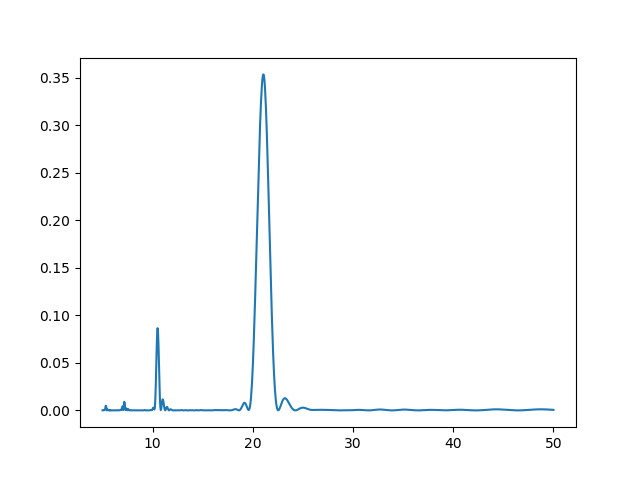

In [103]:
d = np.sum(data, axis=0)
t = np.arange(len(d))
k = np.linspace(5.0, 50., 1000.)
p = stats.LombScargle(t, d).power(1.0/k)
plt.plot(k, p)
plt.show()

In [90]:
k[p[1:].argmax()+1]

21.92184368737475

In [102]:
k[p[10:].argmax()+10]

21.061061061061061

In [106]:
k[p.argmax()]

21.036036036036034

In [296]:
np.sqrt(22**2 + 22**2)

31.11269837220809

In [345]:
pos.swapaxes(1,0)

array([[ 0.587194  , -3.40707453,  1.60165021,  2.27429369,  2.32348527,
         2.60090425,  2.32615537, -4.45970618,  1.77078356, -1.92130847,
         0.84819501,  1.17612184,  0.75960772,  1.69866856,  1.89360071,
         2.30311107,  2.60408141,  2.56632405, -1.51069363, -6.07554392,
         2.31360848,  2.10784605,  2.39718271, -0.21779283,  0.99344711,
         1.34579874,  1.67466478,  1.63842841,  2.07723543,  2.21173558,
         2.58080738,  1.26646439, -4.77571767,  1.58630762,  2.14791301,
         1.89097086,  2.52770809, -0.06697058, -0.04789202,  1.15325165,
         1.56197094,  1.51311694,  1.26405224, -6.84261265,  2.36977148,
         2.49102211,  2.05091482, -0.43445039,  0.19249795,  0.58767101,
         1.58609739,  1.83734063,  2.00003194,  1.68207528, -0.03097384,
         0.77566789,  0.09317753,  0.72240782,  2.55116206,  1.05465872,
        -7.06219193,  1.77040149,  1.81903513,  2.54533476,  0.07597555,
         0.42206653, -0.62127375, -2.2386193 ,  1.0

In [349]:
pos.transpose()

array([[ 0.587194  , -3.40707453,  1.60165021,  2.27429369,  2.32348527,
         2.60090425,  2.32615537, -4.45970618,  1.77078356, -1.92130847,
         0.84819501,  1.17612184,  0.75960772,  1.69866856,  1.89360071,
         2.30311107,  2.60408141,  2.56632405, -1.51069363, -6.07554392,
         2.31360848,  2.10784605,  2.39718271, -0.21779283,  0.99344711,
         1.34579874,  1.67466478,  1.63842841,  2.07723543,  2.21173558,
         2.58080738,  1.26646439, -4.77571767,  1.58630762,  2.14791301,
         1.89097086,  2.52770809, -0.06697058, -0.04789202,  1.15325165,
         1.56197094,  1.51311694,  1.26405224, -6.84261265,  2.36977148,
         2.49102211,  2.05091482, -0.43445039,  0.19249795,  0.58767101,
         1.58609739,  1.83734063,  2.00003194,  1.68207528, -0.03097384,
         0.77566789,  0.09317753,  0.72240782,  2.55116206,  1.05465872,
        -7.06219193,  1.77040149,  1.81903513,  2.54533476,  0.07597555,
         0.42206653, -0.62127375, -2.2386193 ,  1.0